# CS3315 Project Unsupervised Learning

* Train two models: K-means and isolation forest
* K-means would require additional data analysis/interpretation (i.e. what additional insights does clustering provide outside of the labels?)
*Isolation forest - interpolate some kind of "badness" score from the features? (i.e. discovery of new label)]

Code framework from https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### K-Means Clustering

In [ ]:
# import data to dataframe

filename = '/content/2020.06.19.csv'
df = pd.read_csv(filename)
#df.set_index('avg_ipt',inplace=True)
# df.info()
# df.head(4)

In [ ]:
df.dropna(inplace=True)
df.isna().sum()

avg_ipt          0
bytes_in         0
bytes_out        0
dest_ip          0
dest_port        0
entropy          0
num_pkts_out     0
num_pkts_in      0
proto            0
src_ip           0
src_port         0
time_end         0
time_start       0
total_entropy    0
label            0
duration         0
dtype: int64

In [ ]:
# one hot encoding for labels

print('label values:', df['label'].unique())

def ordinal_encoder(category):
    dict = {'benign':0, 'outlier':1, 'malicious':2}
    return dict[category]

print('benign', ordinal_encoder('benign'))
print('outlier', ordinal_encoder('outlier'))
print('malicious', ordinal_encoder('malicious'))
df['label'] = df['label'].apply(ordinal_encoder)

label values: ['benign' 'outlier' 'malicious']
benign 0
outlier 1
malicious 2


In [ ]:
# source ip and labels

features = ['src_ip',
            'label']

X = df[features]

# Scale features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

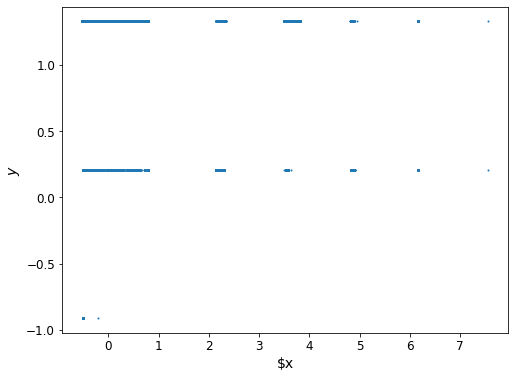

(740863, 2)


array([1, 0, 1, ..., 0, 1, 1], dtype=int32)

In [ ]:
# plotting the data on a scatterplot

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x", fontsize=14)
    plt.ylabel("$y$", fontsize=14, rotation=90)

plt.figure(figsize=(8, 6))
plot_clusters(X)
plt.show()
print(X.shape)


from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit_predict(X)

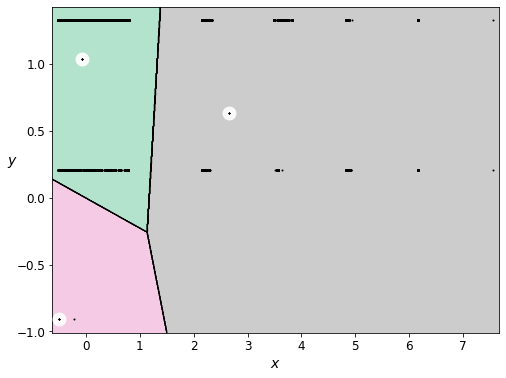

In [ ]:
# applying k-means to the scatterplot

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$y$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 6))
plot_decision_boundaries(kmeans, X)
plt.show()

In [ ]:
# calculating inertia

kmeans.score(X)

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

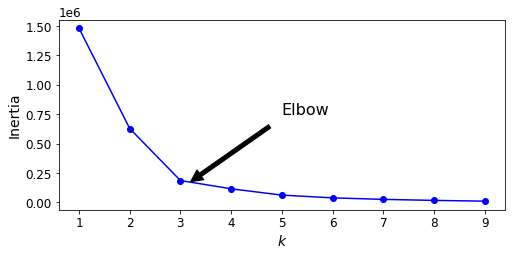

In [ ]:
# plotting inertia

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis()
plt.show()

In [ ]:
# determines best value for k
# takes 1.5  - 2 hrs to run

from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)